# Collecting DEM, Gravity, Magnetic, SAR and Optical Data

The Digital Terrain Models are taken from the platform [Planetary Computer](https://planetarycomputer.microsoft.com/explore)

The Sentinel 1 Level-1 Ground Range Detected (GRD) Data is taken from the platform [Planetary Computer](https://planetarycomputer.microsoft.com/explore)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rioxarray

In [2]:
import sys
import importlib
sys.path.append('../modules')
from reading import ascii_xyz
from plotting import raster_plotting
from processing import interpolate
importlib.reload(raster_plotting);

In [3]:
import os
data_dir = os.path.abspath(os.path.join('..', 'data'))
output_dir = os.path.abspath(os.path.join('..', 'output'))

## DEM

In [17]:
filename = data_dir + '/DEM/combined_dem_pacifico.tif' # DTM taken from planetarycomputer.microsoft.com
topography = xr.load_dataset(filename, engine="rasterio")
topography;

In [18]:
sampling = 5
# region = (-77.3, -76.5, 6.6, 6)
topography_subsampled = topography.isel(x=slice(None, None, sampling), y=slice(None, None, sampling))
# topography_subsampled = topography_subsampled.sel(x=slice(*region[:2]), y=slice(*region[2:]))
topography_subsampled;

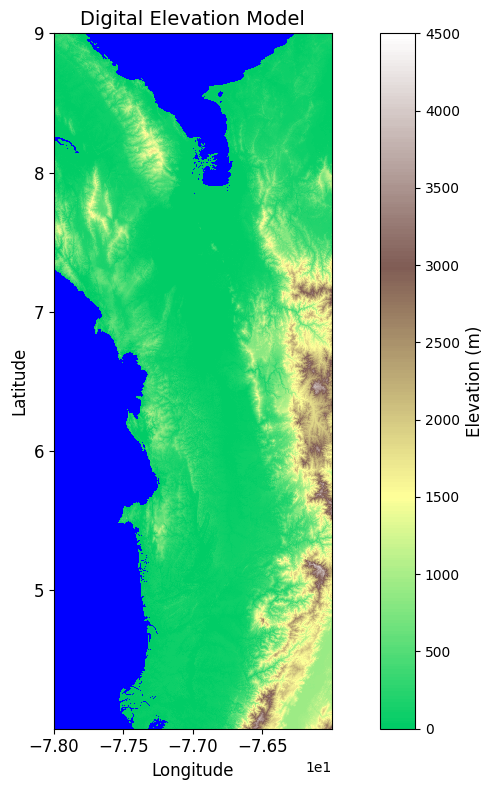

In [19]:
raster_plotting.plot_raster_data(topography_subsampled.x, topography_subsampled.y, topography_subsampled.band_data[0], data_type='DEM')

## Magnetic Data

In [6]:
line_str = 'line'
mag_types = {
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'DIURNAL': float,
    'IGRF': float,
    'OBSMAG': float,
    'TMI_MAG': float,
    line_str: str
}

file_path = os.path.join(data_dir, 'magnetic/PAC_MAG_NORTE', 'PAC_MAG_NORTE.xyz')
magnetic = ascii_xyz.read_ascii_xyz(file_path, line_str, mag_types)
magnetic;

In [7]:
sampling = 10
magnetic_subsampled = magnetic.isel(index=slice(None, None, sampling))
grid_x, grid_y, data_interpolated, data_masked, inside_mask = interpolate.interpolate_data(magnetic_subsampled, var='TMI_MAG', coords_type = ("long", "lat"), alpha=10)

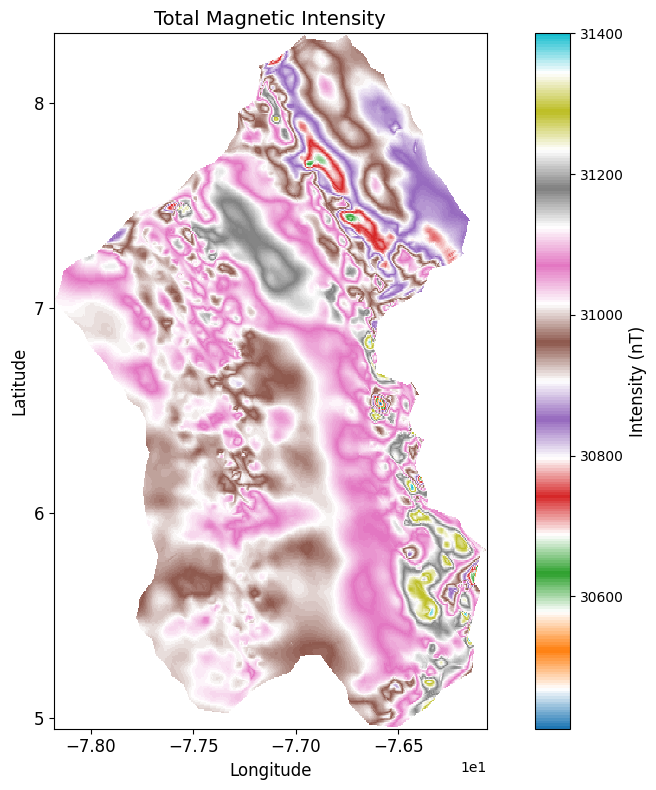

In [8]:
raster_plotting.plot_raster_data(grid_x, grid_y, data_masked.reshape(grid_x.shape), data_type='TMI')

## Gravity Data

In [9]:
line_str = 'line'
grav_types = {
    '/FID': int,
    'JDAY': int,
    'TIME': float,
    'X': float,
    'Y': float,
    'LAT': float,
    'LONG': float,
    'RAW_ALT': float,
    'ADJ_ALT': float,
    'RADAR': float,
    'TERRAIN': float,
    'RAW_VERTACC': float,
    'RAW_BEAMDIFF': float,
    'ADJSPTEN': float,
    'FACORR': float,
    'LATCORR': float,
    'RAWEOTV': float,
    'FILT_EOTV': float,
    'FREEAIR': float,
    'TCOR230': float,
    'BOUG230': float,
    'TCOR267': float,
    'BOUG267': float,
    line_str: str
}

file_path = os.path.join(data_dir, 'gravity/PAC_GRAV_NORTE', 'PAC_GRAV_NORTE.xyz')
gravity = ascii_xyz.read_ascii_xyz(file_path, line_str, grav_types)
gravity;

In [10]:
sampling = 10
gravity_subsampled = gravity.isel(index=slice(None, None, sampling))
grid_x, grid_y, data_interpolated, data_masked, inside_mask = interpolate.interpolate_data(gravity_subsampled, var='BOUG230', coords_type = ("long", "lat"), alpha=10)

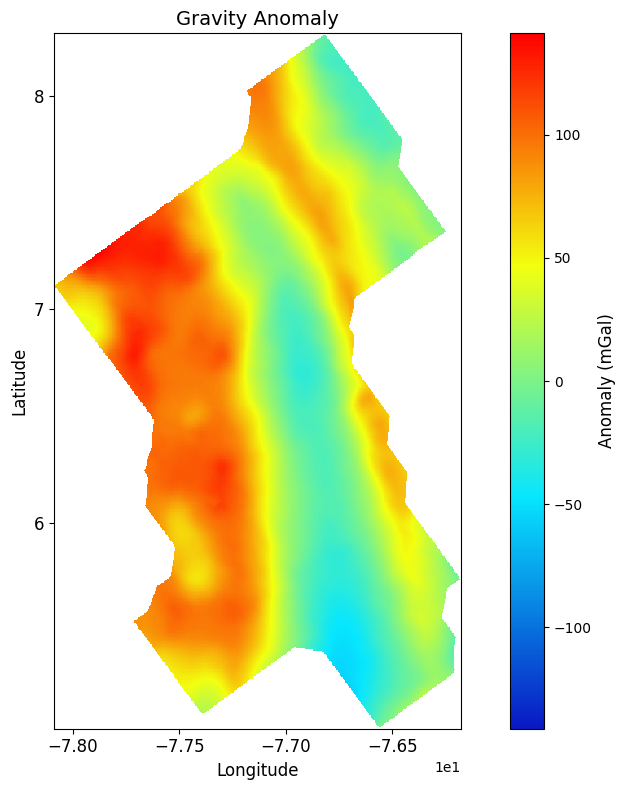

In [11]:
raster_plotting.plot_raster_data(grid_x, grid_y, data_masked.reshape(grid_x.shape), data_type='GA')

## SAR Data

In [12]:
filename = data_dir + '../../data/SAR/sentinel-1_GRD_VH.tif' # DTM taken from planetarycomputer.microsoft.com
SAR = rioxarray.open_rasterio(filename)
SAR;

In [13]:
sampling = 10
SAR_sampled = SAR.isel(
    x=slice(None, None, sampling),
    y=slice(None, None, sampling)
)
SAR_sampled;

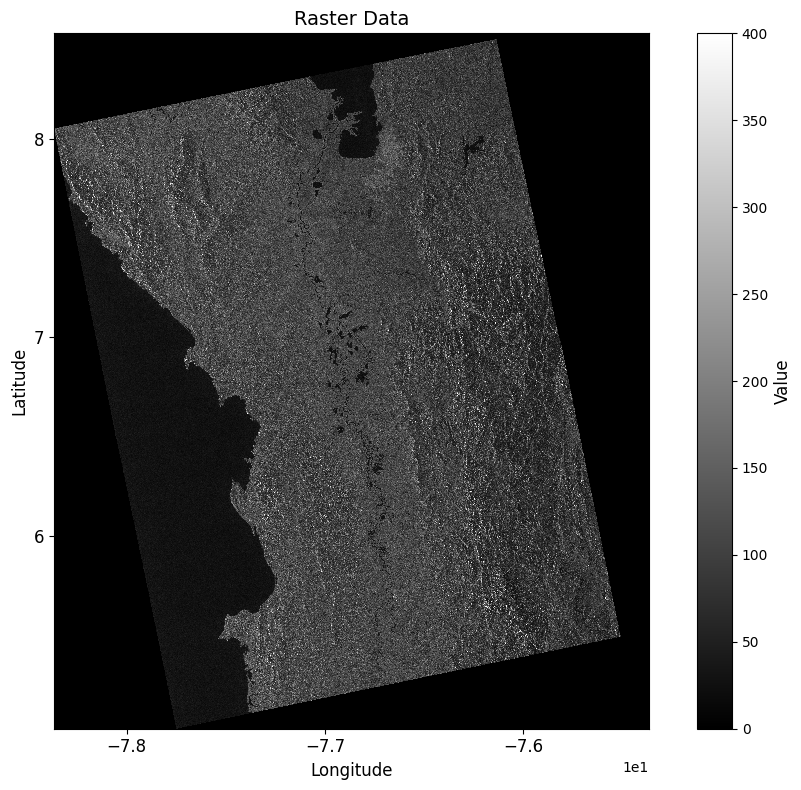

In [14]:
raster_plotting.plot_raster_data(SAR_sampled.x, SAR_sampled.y, SAR_sampled[0], vmax=400)